In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import numpy as np
import keras.optimizers
import keras.initializers

Using TensorFlow backend.


In [16]:
from numpy import linalg as LA
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, add
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
import copy

In [3]:
(trainclass, trainlabels), (testclass, testlabels) = mnist.load_data()
trainclass = trainclass.reshape(len(trainclass),28*28)
testclass = testclass.reshape(len(testclass),28*28)
trainclass = trainclass[0:10000]
testclass = testclass[0:1000]
trainlabels = trainlabels[0:10000]
testlabels = testlabels[0:1000]
testclass = testclass/255
trainclass = trainclass/255
predtrain  = keras.utils.to_categorical(trainlabels,10)
predtest  = keras.utils.to_categorical(testlabels,10)

In [4]:
input_size = 784
hidden_size = 128
code_size = 64
epochs = 20
batch_size = 128
temp = [10,50,100,300,400,500]
encoders = []
for i in range(len(temp)):
    hidden_size = temp[i]
    code_size = temp[i]//2
    x = Input(shape=(input_size,))
    hidden_1 = Dense(hidden_size, activation='relu')(x)
    h = Dense(code_size, activation='relu')(hidden_1)
    hidden_2 = Dense(hidden_size, activation='relu')(h)
    r = Dense(input_size, activation='sigmoid')(hidden_2)
    autoencoder = Model(inputs=x, outputs=r)
    autoencoder.compile(optimizer=keras.optimizers.Adam(), loss='mse')
    history = autoencoder.fit(trainclass,trainclass, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(testclass,testclass))
    encoders.append(Model(autoencoder.input,autoencoder.layers[-3].output))

In [5]:
# print(autoencoder.layers)
for encoder in encoders:
    encoder.summary()
    testpred = encoder.predict(testclass)
    print(testpred.shape)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 7,905
Trainable params: 7,905
Non-trainable params: 0
_________________________________________________________________
(1000, 5)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                39250     
______________________________

In [11]:
model_raw = SVC(C=.1,kernel = 'linear')
model_raw.fit(trainclass,trainlabels)
raw_preds = model_raw.predict(testclass)

In [13]:
accuracy_raw = 0
for i in range(len(testlabels)):
    if(raw_preds[i]==testlabels[i]):
        accuracy_raw +=1
print(accuracy_raw/10)

91.9


In [8]:
model_encode = SVC(C=.1,kernel='linear')
accs = []
for encoder in encoders:
    encoded_train = encoder.predict(trainclass)
    encoded_test = encoder.predict(testclass)
    model_encode.fit(encoded_train,trainlabels)
    preds = model_encode.predict(encoded_test)
    accuracy_encode = 0
    for i in range(len(testlabels)):
        if(preds[i]==testlabels[i]):
            accuracy_encode +=1
    print(accuracy_encode/10)
    accs.append(accuracy_encode/10)

58.7
89.2
91.0
90.4
91.5
92.1


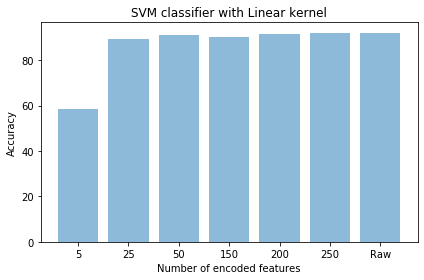

In [19]:
temp = [10,50,100,300,400,500]
accs = [58.7, 89.2, 91.0, 90.4, 91.5, 92.1]
neurons = [temp[i]//2 for i in range(len(temp))]
neurons.append("Raw")
y_pos = np.arange(len(neurons))
temp2 = copy.deepcopy(accs)
temp2.append(accuracy_raw/10)
plt.bar(y_pos,temp2, align='center', alpha=0.5)
plt.xticks(y_pos, neurons)
plt.ylabel('Accuracy')
plt.xlabel("Number of encoded features")
plt.title('SVM classifier with Linear kernel')
plt.tight_layout()
plt.show()